In [1]:
!git clone https://github.com/mjang01011/CS230-Detecting-Transients-in-LSST-Observatory-Data.git
%cd CS230-Detecting-Transients-in-LSST-Observatory-Data

Cloning into 'CS230-Detecting-Transients-in-LSST-Observatory-Data'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 178 (delta 79), reused 150 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (178/178), 39.66 MiB | 20.20 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/CS230-Detecting-Transients-in-LSST-Observatory-Data


In [2]:
from google.colab import files
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

 Load Data

In [4]:
input_csv = '/content/drive/MyDrive/CS230/data/processed_training.csv'
# input_csv = '/content/drive/MyDrive/CS230/data/processed_training_asinh_norm.csv'
# input_csv = '/content/drive/MyDrive/CS230/data/processed_training_gp_asinh.csv' # this one for gp + asinh
max_length = 200
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
df = pd.read_csv(input_csv)
print(f"Loaded {len(df)} observations for {df['object_id'].nunique()} objects")
print(f"Columns: {list(df.columns)}")

Loaded 1419114 observations for 7806 objects
Columns: ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected', 't_peak', 'flux_peak', 't_centered', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target']


In [6]:
from lib.dataset import LightCurveDataset
max_length = 200

# using our definition of dataset from git repo
dataset = LightCurveDataset(input_csv, max_length=max_length, use_flux_only=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Target mapping: {dataset.target_mapping}")

{np.int64(6): 0, np.int64(15): 1, np.int64(16): 2, np.int64(42): 3, np.int64(52): 4, np.int64(53): 5, np.int64(62): 6, np.int64(64): 7, np.int64(65): 8, np.int64(67): 9, np.int64(88): 10, np.int64(90): 11, np.int64(92): 12, np.int64(95): 13}
Dataset size: 7806
Number of classes: 14
Target mapping: {np.int64(6): 0, np.int64(15): 1, np.int64(16): 2, np.int64(42): 3, np.int64(52): 4, np.int64(53): 5, np.int64(62): 6, np.int64(64): 7, np.int64(65): 8, np.int64(67): 9, np.int64(88): 10, np.int64(90): 11, np.int64(92): 12, np.int64(95): 13}


## 3. Remap Labels to Contiguous Range

In [7]:
num_classes = dataset.num_classes
label_mapping = dataset.target_mapping
reverse_label_mapping = dataset.ordered_labels

print(f"Label mapping: {label_mapping}")
print(f"Number of classes: {num_classes}")

object_ids = sorted(df['object_id'].unique())
all_labels = []
for obj_id in object_ids:
    target = df[df['object_id'] == obj_id]['target'].iloc[0]
    all_labels.append(label_mapping[target])
all_labels = np.array(all_labels)

print(f"Total objects: {len(all_labels)}")

Label mapping: {np.int64(6): 0, np.int64(15): 1, np.int64(16): 2, np.int64(42): 3, np.int64(52): 4, np.int64(53): 5, np.int64(62): 6, np.int64(64): 7, np.int64(65): 8, np.int64(67): 9, np.int64(88): 10, np.int64(90): 11, np.int64(92): 12, np.int64(95): 13}
Number of classes: 14
Total objects: 7806


Single class for RNN/LSTM/GRU

In [8]:
# can also pull from the git repo, we defined basic classes for each
class RecurrentClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2,
                 rnn_type='RNN', dropout=0.2, n_classes=14):
        super().__init__()
        self.rnn_type = rnn_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers,batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_dim, hidden_dim, num_layers,
                batch_first=True, dropout=dropout
            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        if self.rnn_type == 'LSTM':
            output, (hidden, cell) = self.rnn(x)
            hidden = hidden[-1]
        else:
            output, hidden = self.rnn(x)
            hidden = hidden[-1]

        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

In [9]:
from torch.utils.data import Subset

indices = list(range(len(dataset)))
idx_temp, idx_test = train_test_split(
    indices,
    test_size=0.1, random_state=42, stratify=all_labels
)
y_temp = all_labels[idx_temp]
idx_train, idx_val = train_test_split(
    idx_temp,
    test_size=0.1111, random_state=42, stratify=y_temp
)
train_dataset = Subset(dataset, idx_train)
val_dataset = Subset(dataset, idx_val)
test_dataset = Subset(dataset, idx_test)

y_train = all_labels[idx_train]
y_val = all_labels[idx_val]
y_test = all_labels[idx_test]

print(f"Train: {len(y_train)} ({len(y_train)/len(all_labels)*100:.1f}%)")
print(f"Val: {len(y_val)} ({len(y_val)/len(all_labels)*100:.1f}%)")
print(f"Test: {len(y_test)} ({len(y_test)/len(all_labels)*100:.1f}%)")

Train: 6244 (80.0%)
Val: 781 (10.0%)
Test: 781 (10.0%)


In [12]:
# make sure we get the same statistics. check class 11 has 230 points
def show_split_statistics(y_train, y_val, y_test):
    classes = np.unique(np.concatenate([y_train, y_val, y_test]))

    results = []
    for cls in classes:
        train_count = np.sum(y_train == cls)
        val_count = np.sum(y_val == cls)
        test_count = np.sum(y_test == cls)
        total = train_count + val_count + test_count

        results.append({
            'Class': int(cls),
            'Train': train_count,
            'Train %': f"{100 * train_count / len(y_train):.2f}%",
            'Val': val_count,
            'Val %': f"{100 * val_count / len(y_val):.2f}%",
            'Test': test_count,
            'Test %': f"{100 * test_count / len(y_test):.2f}%",
            'Total': total
        })

    df = pd.DataFrame(results)

    totals = {
        'Class': 'TOTAL',
        'Train': len(y_train),
        'Train %': '100.00%',
        'Val': len(y_val),
        'Val %': '100.00%',
        'Test': len(y_test),
        'Test %': '100.00%',
        'Total': len(y_train) + len(y_val) + len(y_test)
    }
    df = pd.concat([df, pd.DataFrame([totals])], ignore_index=True)

    print("\n" + "="*80)
    print("TRAIN/VAL/TEST SPLIT STATISTICS")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    print(f"Split ratio: {len(y_train)}/{len(y_val)}/{len(y_test)} = "
          f"{100*len(y_train)/(len(y_train)+len(y_val)+len(y_test)):.1f}%/"
          f"{100*len(y_val)/(len(y_train)+len(y_val)+len(y_test)):.1f}%/"
          f"{100*len(y_test)/(len(y_train)+len(y_val)+len(y_test)):.1f}%")
    print("="*80 + "\n")

    return df

split_df = show_split_statistics(y_train, y_val, y_test)


TRAIN/VAL/TEST SPLIT STATISTICS
Class  Train Train %  Val   Val %  Test  Test %  Total
    0    120   1.92%   15   1.92%    15   1.92%    150
    1    394   6.31%   49   6.27%    49   6.27%    492
    2    735  11.77%   92  11.78%    92  11.78%    919
    3    947  15.17%  118  15.11%   119  15.24%   1184
    4    146   2.34%   18   2.30%    18   2.30%    182
    5     24   0.38%    3   0.38%     3   0.38%     30
    6    386   6.18%   48   6.15%    48   6.15%    482
    7     82   1.31%   10   1.28%    10   1.28%    102
    8    784  12.56%   98  12.55%    98  12.55%    980
    9    166   2.66%   21   2.69%    21   2.69%    208
   10    294   4.71%   37   4.74%    37   4.74%    368
   11   1838  29.44%  230  29.45%   230  29.45%   2298
   12    189   3.03%   24   3.07%    24   3.07%    237
   13    139   2.23%   18   2.30%    17   2.18%    174
TOTAL   6244 100.00%  781 100.00%   781 100.00%   7806
Split ratio: 6244/781/781 = 80.0%/10.0%/10.0%



Trainers

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels

Grid Search Parameters

In [ ]:
param_grid = {
    'rnn_type': ['RNN', 'LSTM', 'GRU'],
    'hidden_dim': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'dropout': [0.2, 0.3],
    'lr': [1e-4, 1e-3],
    'weight_decay': [1e-5, 1e-4]
}

In [16]:
def train_with_params(rnn_type, hidden_dim, num_layers, dropout, lr, weight_decay, num_epochs=50):
    model = RecurrentClassifier(
        input_dim=1,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        rnn_type=rnn_type,
        dropout=dropout,
        n_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    return best_model_state, best_val_loss, train_losses, val_losses

In [17]:
results = []
config_idx = 0

for rnn_type in param_grid['rnn_type']:
    for hidden_dim in param_grid['hidden_dim']:
        for num_layers in param_grid['num_layers']:
            for dropout in param_grid['dropout']:
                for lr in param_grid['lr']:
                    for weight_decay in param_grid['weight_decay']:
                        config_idx += 1
                        print(f"\n[{config_idx}/{total_combinations}] {rnn_type}, hidden={hidden_dim}, layers={num_layers}, dropout={dropout}, lr={lr}, wd={weight_decay}")

                        model_state, val_loss, train_losses, val_losses = train_with_params(
                            rnn_type, hidden_dim, num_layers, dropout, lr, weight_decay
                        )

                        results.append({
                            'rnn_type': rnn_type,
                            'hidden_dim': hidden_dim,
                            'num_layers': num_layers,
                            'dropout': dropout,
                            'lr': lr,
                            'weight_decay': weight_decay,
                            'val_loss': val_loss,
                            'model_state': model_state,
                            'train_losses': train_losses,
                            'val_losses': val_losses
                        })
                        print(f"Best Val Loss: {val_loss:.4f}")

results.sort(key=lambda x: x['val_loss'])
best_config = results[0]

print("\n" + "="*80)
print("OVERALL Best Configuration:")
print(f"Type={best_config['rnn_type']}, hidden_dim={best_config['hidden_dim']}, num_layers={best_config['num_layers']}")
print(f"dropout={best_config['dropout']}, lr={best_config['lr']}, weight_decay={best_config['weight_decay']}")
print(f"Best Val Loss: {best_config['val_loss']:.4f}")

print("\n" + "="*80)
print("Best Configuration PER MODEL TYPE:")
best_configs_per_type = {}
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    type_results = [r for r in results if r['rnn_type'] == rnn_type]
    if type_results:
        best_for_type = min(type_results, key=lambda x: x['val_loss'])
        best_configs_per_type[rnn_type] = best_for_type
        print(f"\n{rnn_type}:")
        print(f"  hidden_dim={best_for_type['hidden_dim']}, num_layers={best_for_type['num_layers']}")
        print(f"  dropout={best_for_type['dropout']}, lr={best_for_type['lr']}, weight_decay={best_for_type['weight_decay']}")
        print(f"  Val Loss: {best_for_type['val_loss']:.4f}")
print("="*80)


[1/216] RNN, hidden=64, layers=1, dropout=0.2, lr=0.0001, wd=1e-05
Best Val Loss: 2.1604

[2/216] RNN, hidden=64, layers=1, dropout=0.2, lr=0.0001, wd=0.0001
Best Val Loss: 2.1612

[3/216] RNN, hidden=64, layers=1, dropout=0.2, lr=0.001, wd=1e-05
Best Val Loss: 2.0512

[4/216] RNN, hidden=64, layers=1, dropout=0.2, lr=0.001, wd=0.0001
Best Val Loss: 2.0547

[5/216] RNN, hidden=64, layers=1, dropout=0.3, lr=0.0001, wd=1e-05
Best Val Loss: 2.1611

[6/216] RNN, hidden=64, layers=1, dropout=0.3, lr=0.0001, wd=0.0001
Best Val Loss: 2.1599

[7/216] RNN, hidden=64, layers=1, dropout=0.3, lr=0.001, wd=1e-05
Best Val Loss: 2.0655

[8/216] RNN, hidden=64, layers=1, dropout=0.3, lr=0.001, wd=0.0001
Best Val Loss: 2.0715

[9/216] RNN, hidden=64, layers=2, dropout=0.2, lr=0.0001, wd=1e-05
Best Val Loss: 2.1112

[10/216] RNN, hidden=64, layers=2, dropout=0.2, lr=0.0001, wd=0.0001
Best Val Loss: 2.1599

[11/216] RNN, hidden=64, layers=2, dropout=0.2, lr=0.001, wd=1e-05
Best Val Loss: 2.0252

[12/216

Evaluation

In [24]:
from sklearn.metrics import f1_score

test_results_per_type = {}

for rnn_type in ['RNN', 'LSTM', 'GRU']:
    if rnn_type in best_configs_per_type:
        config = best_configs_per_type[rnn_type]

        print(f"\n{rnn_type}:")
        print(f"  Config: hidden={config['hidden_dim']}, layers={config['num_layers']}, dropout={config['dropout']}")

        model = RecurrentClassifier(
            input_dim=1,
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            rnn_type=config['rnn_type'],
            dropout=config['dropout'],
            n_classes=num_classes
        ).to(device)

        model.load_state_dict(config['model_state'])
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        criterion = nn.CrossEntropyLoss()

        test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

        # Calculate macro F1 score
        macro_f1 = f1_score(test_labels, test_preds, average='macro')

        test_results_per_type[rnn_type] = {
            'test_loss': test_loss,
            'test_acc': test_acc,
            'macro_f1': macro_f1,
            'test_preds': test_preds,
            'test_labels': test_labels
        }

        print(f"  Test Loss: {test_loss:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Macro F1: {macro_f1:.4f}")

print("\n" + "="*80)
print("Test Set Performance Comparison:")
print("="*80)
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    if rnn_type in test_results_per_type:
        print(f"{rnn_type:6s} - Loss: {test_results_per_type[rnn_type]['test_loss']:.4f}, "
              f"Acc: {test_results_per_type[rnn_type]['test_acc']:.4f}, "
              f"Macro F1: {test_results_per_type[rnn_type]['macro_f1']:.4f}")
print("="*80)


Evaluating Best Model Per Type on Test Set

RNN:
  Config: hidden=128, layers=2, dropout=0.2
  Test Loss: 2.1448
  Test Accuracy: 0.3060
  Macro F1: 0.0480

LSTM:
  Config: hidden=256, layers=1, dropout=0.3
  Test Loss: 1.2662
  Test Accuracy: 0.5416
  Macro F1: 0.2813

GRU:
  Config: hidden=256, layers=3, dropout=0.2
  Test Loss: 1.7026
  Test Accuracy: 0.6645
  Macro F1: 0.5484

Test Set Performance Comparison:
RNN    - Loss: 2.1448, Acc: 0.3060, Macro F1: 0.0480
LSTM   - Loss: 1.2662, Acc: 0.5416, Macro F1: 0.2813
GRU    - Loss: 1.7026, Acc: 0.6645, Macro F1: 0.5484


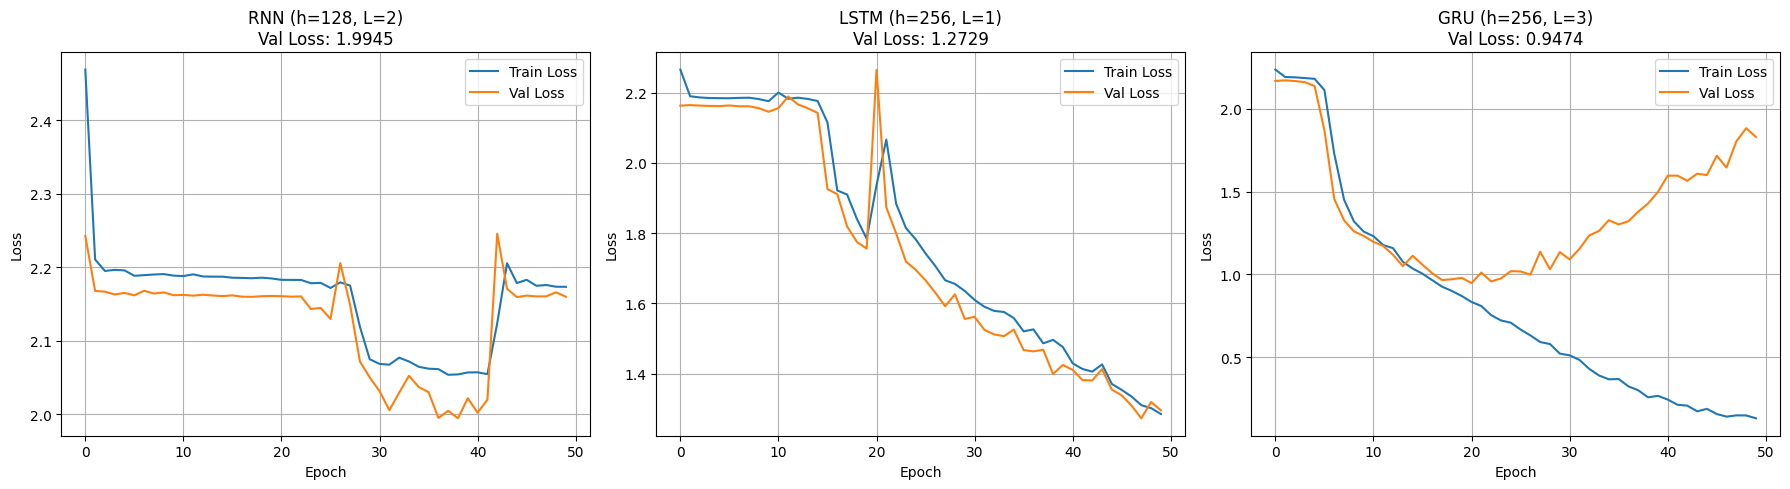

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, rnn_type in enumerate(['RNN', 'LSTM', 'GRU']):
    if rnn_type in best_configs_per_type:
        config = best_configs_per_type[rnn_type]
        ax = axes[idx]
        ax.plot(config['train_losses'], label='Train Loss')
        ax.plot(config['val_losses'], label='Val Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'{rnn_type} (h={config["hidden_dim"]}, L={config["num_layers"]})\nVal Loss: {config["val_loss"]:.4f}')
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.savefig('training_curves_per_type.png', dpi=300)
plt.show()

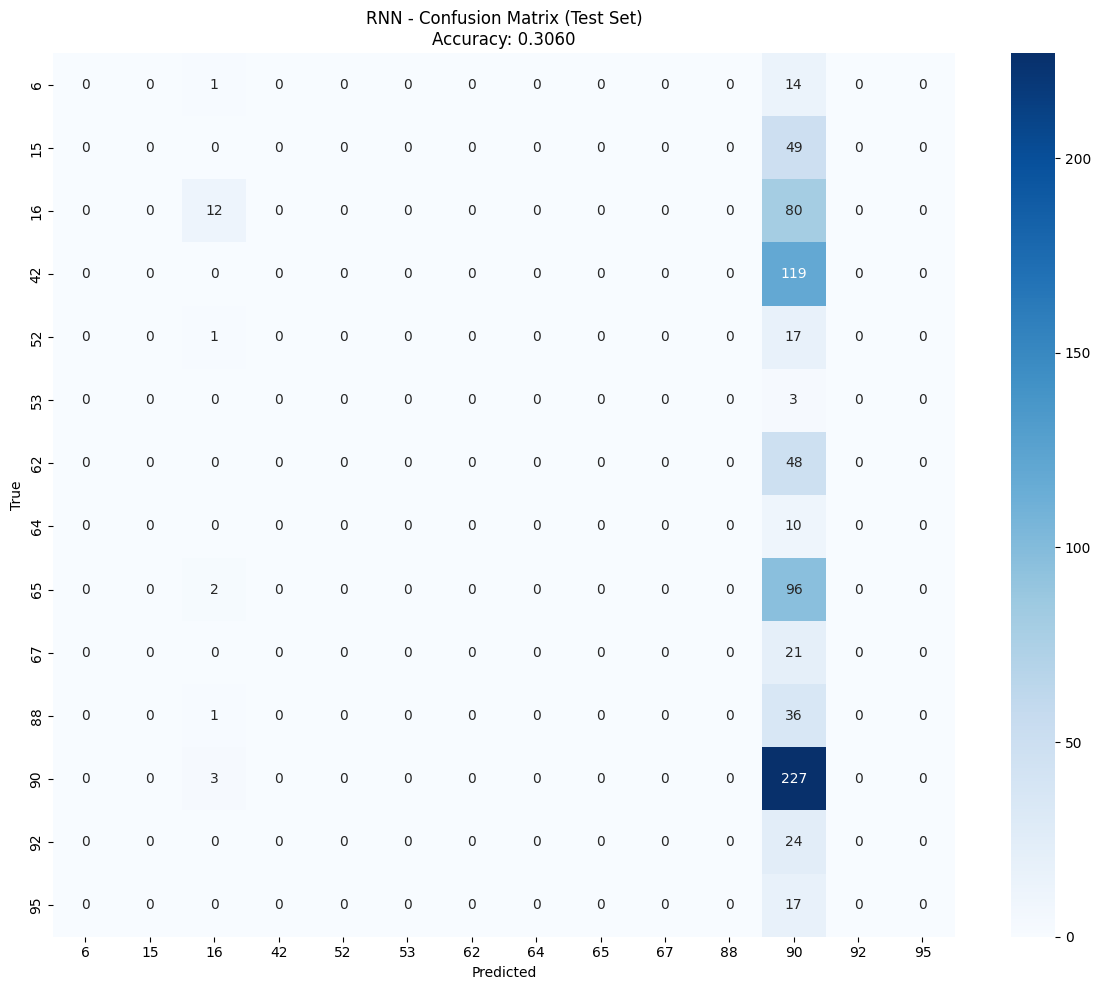

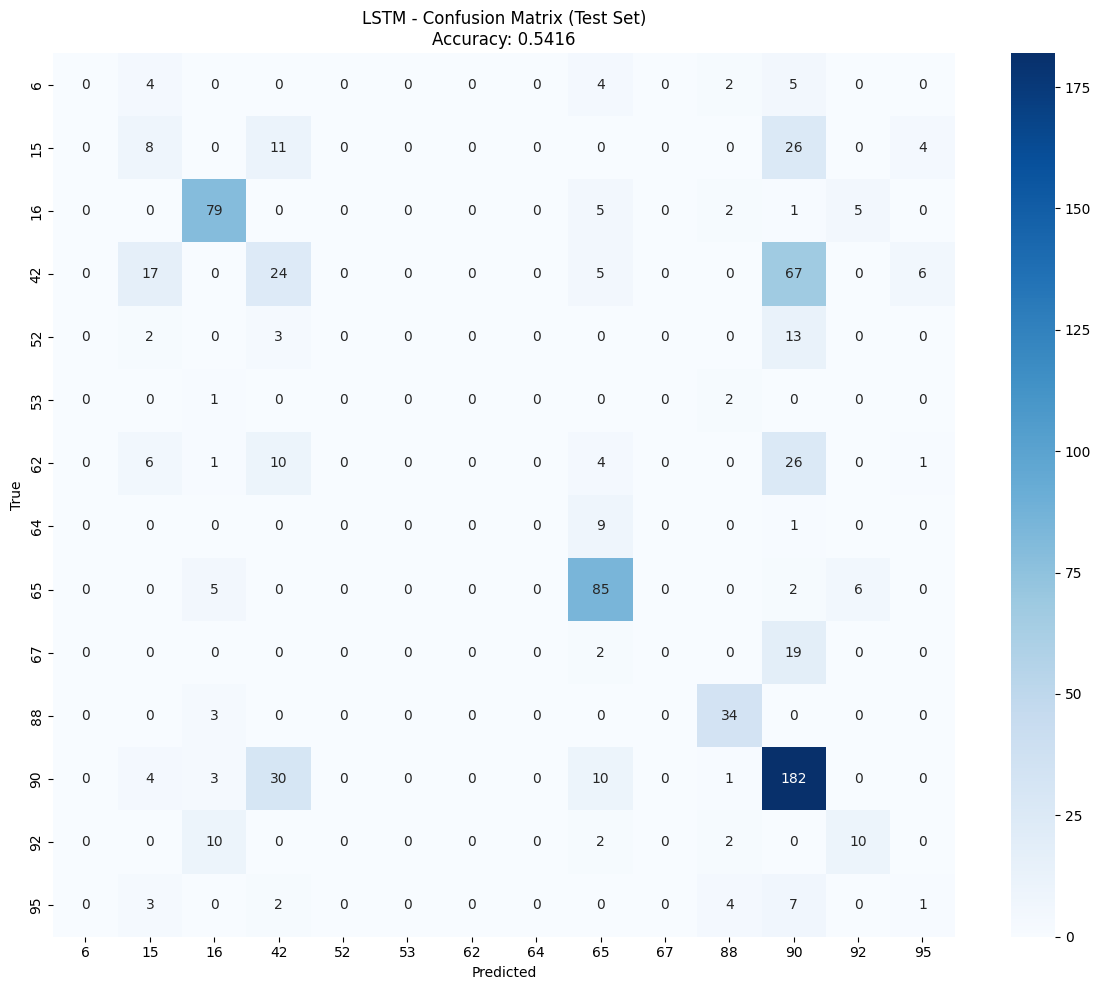

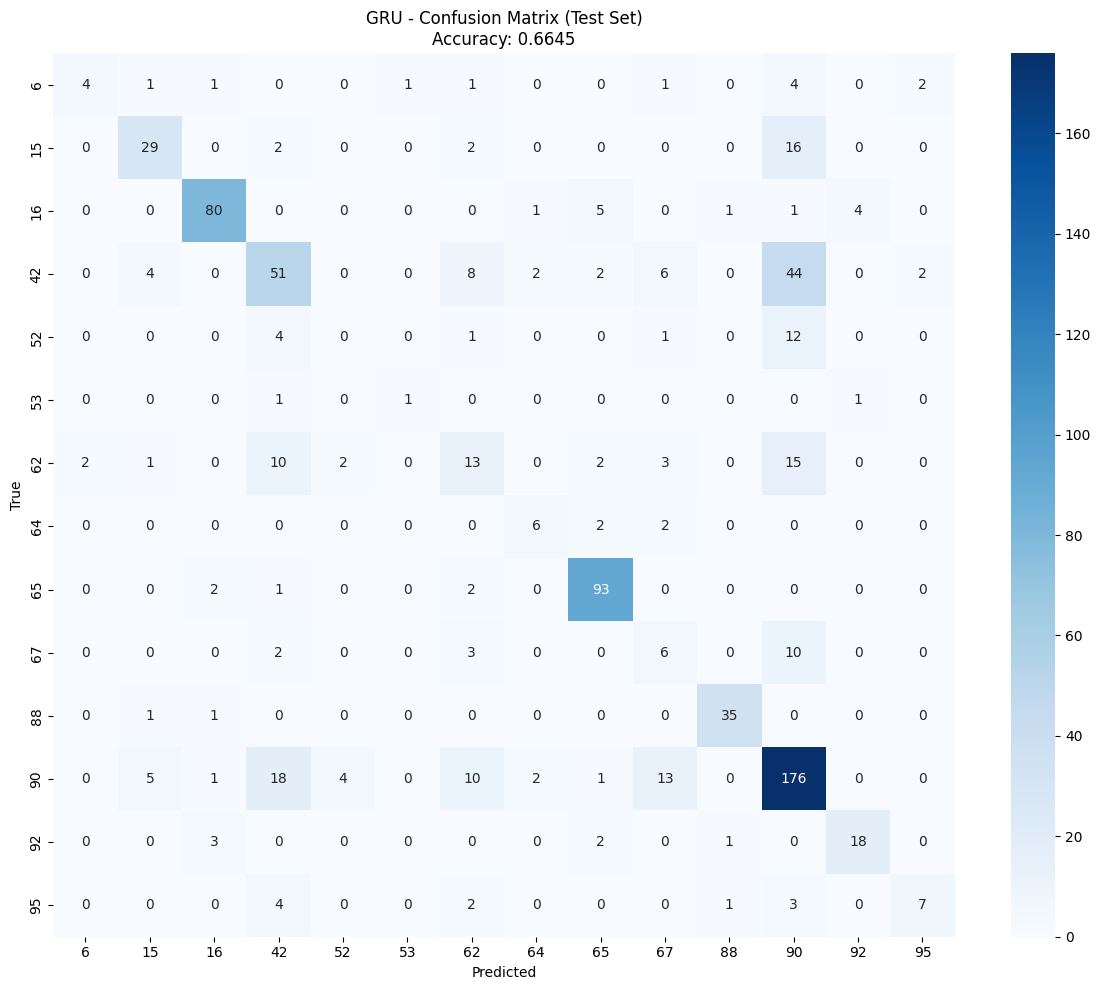

In [25]:
# get CM
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    if rnn_type in test_results_per_type:
        test_preds = test_results_per_type[rnn_type]['test_preds']
        test_labels = test_results_per_type[rnn_type]['test_labels']

        cm = confusion_matrix(test_labels, test_preds)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f"{reverse_label_mapping[i]}" for i in range(num_classes)],
                    yticklabels=[f"{reverse_label_mapping[i]}" for i in range(num_classes)])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{rnn_type} - Confusion Matrix (Test Set)\nAccuracy: {test_results_per_type[rnn_type]["test_acc"]:.4f}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{rnn_type.lower()}_test.png', dpi=300)
        plt.show()